### Clustering Molecules With a Self-Organizing Map (SOM)
This notebook provides an overview of the use of self-organizing maps (SOMs) in cheminformatics. For a bit of background on SOMs, please see this [blog post](http://practicalcheminformatics.blogspot.com/2018/10/self-organizing-maps-90s-fad-or-useful.html)

### Setup

Install the necessary Python libraries

In [ ]:
!pip install minisom tqdm rdkit_pypi

Import the necessary Python libraries

In [52]:
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Draw
from rdkit import DataStructs
import numpy as np
from tqdm.auto import tqdm
from minisom import MiniSom
import sys
from time import time
import math
import mols2grid
from ipywidgets import interact

Enable matplotlib plots in the this notebook

In [2]:
%matplotlib inline

#### Defining a Few Useful Functions
A few functions to generate fingerprints. The first function generates 166-bit MACCS keys.  The second generates Morgan fingerprints.  While both will work for building a SOM, the process will be a bit faster with MACCS keys. I tend to like MACCS keys for generating SOMs.  These fingerprints typically do a good job of grouping a set of molecules by scaffold. The third function takes a list of SMILES as input and returns as a list of fingerprints. If this function is called with one argument, it generates MACCS keys.  We can also pass a function as a second argument to generate a different fingerprint type.  For instance, we could call it like this to generate Morgan fingerprints.  
```
generate_fps(my_smiles_list,morgan_as_np)
```

In [3]:
def maccs_as_np(mol):
    """
    Generate MACCS fingerprints as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = MACCSkeys.GenMACCSKeys(mol)
    return np.array([int(x) for x in list(bv.ToBitString())], dtype=np.float32)


def morgan_as_np(mol):
    """
    Generate a 1024 bit Morgan fingerprint as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    arr = np.zeros((1,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr


def generate_fps(smiles_list, fp_function=maccs_as_np):
    """
    Take a list of SMILES as input and return a list of NumPy arrays
    :param smiles_list: list of SMILES
    :param fp_function: function to calculate fingerprints
    :return: list of NumPy arrays containing fingerprints
    """
    output_fp_list = []
    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):
        output_fp_list.append(fp_function(Chem.MolFromSmiles(smiles)))
    return output_fp_list

A function to generate a grid of pie charts showing the distribution of active and inactive compounds in each grid cell. 

In [13]:
# Adapted from the MiniSom example notebook
def depict_som(cluster_df, x_dim, y_dim, x_column="X", y_column="Y", activity_column="is_active"):
    """
    Draw a SOM with each cell depicted as a pie chart
    :param cluster_df: data frame with SOM output, should have columns active, X, and Y
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :return:
    """
    required_colums = [x_column, y_column, activity_column]
    for col in required_colums:
        if col not in cluster_df.columns:
            print(f"Error {col} not in dataframe columns", file=sys.stderr)
            sys.exit(1)
    cell_dict = {}
    for k, v in [x for x in cluster_df.groupby([x_column, y_column])]:
        cell_dict[k] = Counter(v[activity_column])
        cell_names = cluster_df[activity_column].unique()
    plt.figure(figsize=(x_dim, y_dim))
    the_grid = GridSpec(x_dim, y_dim)
    for position in cell_dict.keys():
        label_fracs = [cell_dict[position][l] for l in cell_names]
        plt.subplot(the_grid[(x_dim - 1) - position[1], position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

Build a SOM with minisom

In [14]:
def build_minisom_som(fp_list_in, x_dim=10, y_dim=10, num_iters=20000):
    """
    Build a SOM with MiniSom
    :param fp_list_in: input list of fingerprints as NumPy arrays
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :param num_iters: number of iterations when building the SOM
    :return: lists with X and Y coordinates in the SOM
    """
    print("Training SOM")
    start_time = time()
    som = MiniSom(x_dim, y_dim, len(fp_list_in[0]), sigma=0.3, learning_rate=0.5, random_seed=1)
    som.train_random(fp_list_in, num_iters)
    x = []
    y = []
    # find best matching units
    print("Finding BMUs")
    for row in fp_list_in:
        x_val, y_val = som.winner(row)
        x.append(x_val)
        y.append(y_val)
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return x, y

#### Reading the Input Data
Now that we have the necessary functions in place, we can have some fun.  We will read in a csv file containing SMILES, a molecule name, and 1 or 0 indicating that the molecule is active into a Pandas data frame. 

We then use the function generate_fps to generate a list of fingerprints from the SMILES column in the dataframe. This list of fingerprints is then used to generate X and Y coordinates for each molecule in the grid.  The x and y coordinates generated by build_minisom_som are then added as columns to the original dataframe.  This dataframe, as well as the grid dimensions, are then passed to the depiction function to generate the plot below. 

In [15]:
act_df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/dude_erk2_mk01.csv")
act_df.head()

,Unnamed: 0,SMILES,ID,is_active
0,0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


#### Adding Labels
Active and decoy are currently indicated by 1 and 0 in the dataframe.  To have better labels, we will convert 1 and 0 to the strings **active** and **decoy** and add new column called **label**.

In [31]:
act_df['label'] = ["active" if i == 1 else "inactive" for i in act_df.is_active]

In [32]:
act_df.label.value_counts()

inactive    4550
active        79
Name: label, dtype: int64

In [33]:
act_df.head()

,Unnamed: 0,SMILES,ID,is_active,label,X,Y,morgan_X,morgan_Y
0,0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1,active,2,0,6,8
1,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1,active,6,6,6,3
2,2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1,active,6,6,1,2
3,3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1,active,6,6,1,2
4,4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1,active,6,6,1,2


#### Building and Displaying the SOM
Now we'll generate fingerprints for the molecules, the build and display the SOM.

The dataset we used above is the [ERK2 (aka MK01)](http://dude.docking.org/targets/mk01) dataset that is part of the [DUD-E dataset](http://dude.docking.org/), which was designed for the evaluation of docking programs.  The DUDE-E database consists of sets of active compounds, curated from the literature, and decoy compounds with similar calculated properties (molecular weight, LogP).  The compound sets in the database were designed to evaluate the ability of a docking program to distinguish active compounds from decoys.  

In the plot above the active compounds are shown in blue, while the decoy compounds are shown in orange.  As we can see, our fingerprints do a reasonably good job of separating the active compounds from the decoys.  In particular, we see that one cell at position 6,4 (we start counting from 0) is highly enriched in active compounds.  Let's take a closer look at molecules in that cell.  

Generating Fingerprints:   0%|          | 0/4629 [00:00<?, ?it/s]

Training SOM
Finding BMUs
Done
Elapsed time = 8.03 sec


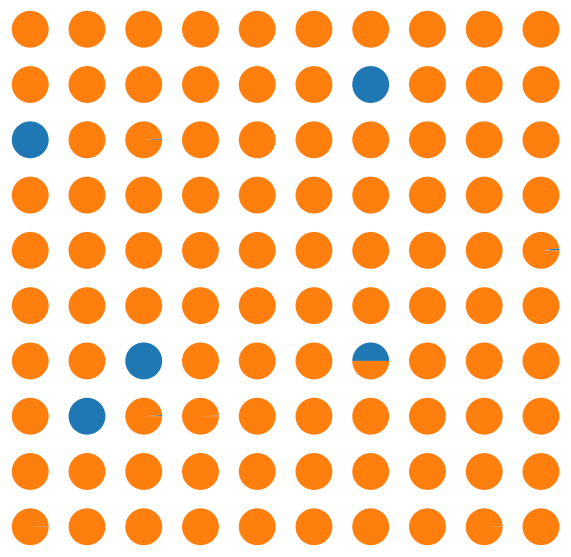

In [23]:
morgan_list = generate_fps(act_df.SMILES,morgan_as_np)
x_dim = 10
y_dim = 10
morgan_x, morgan_y = build_minisom_som(morgan_list, x_dim, y_dim)
act_df["morgan_X"] = morgan_x
act_df["morgan_Y"] = morgan_y
depict_som(act_df, x_dim, y_dim, x_column="morgan_X",y_column="morgan_Y")

#### Creating an Interactive Viewer
Let's define a function that will display the molecules in a particular cell.  We'll use the Jupyter [interact](https://colab.research.google.com/github/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Using%20Interact.ipynb) widget to make an interactive tool.  Note that cells are numbered from 0, with cell (0,0) in the bottom left corner. 

In [51]:
@interact(x=range(0,x_dim), y=range(0,y_dim))
def display_mols(x, y):
    return mols2grid.display(act_df.query("morgan_X==@x and morgan_Y==@y"),subset=["img","ID","label"])

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(des…